# Bennets Hipathia Script

## 1. Instalation 

In [1]:
# 1) Define packages
cran_pkgs <- c("dplyr", "pheatmap", "data.table", "matrixStats", "irlba")
bioc_pkgs <- c("edgeR", "hipathia")

# 2) CRAN: install missing
missing_cran <- cran_pkgs[!sapply(cran_pkgs, requireNamespace, quietly = TRUE)]
if (length(missing_cran)) install.packages(missing_cran)

# 3) Bioconductor: ensure BiocManager + set Bioc 3.18 + install missing
if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
BiocManager::install(version = "3.18", ask = FALSE)

missing_bioc <- bioc_pkgs[!sapply(bioc_pkgs, requireNamespace, quietly = TRUE)]
if (length(missing_bioc)) BiocManager::install(missing_bioc, ask = FALSE, update = FALSE)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Old packages: 'data.table', 'DBI', 'ggpubr', 'igraph'

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘data.table’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘igraph’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## 2. Parameters & libraries

### 2.1 Set Paramter 

In [2]:

# 5) versions for documentation
cat("R:", as.character(getRversion()), "\n")
cat("Bioconductor:", as.character(BiocManager::version()), "\n")
cat("hipathia:", as.character(packageVersion("hipathia")), "\n")
cat("dplyr:", as.character(packageVersion("dplyr")), "\n")

#  Input files 
rna_path  <- "RNA_filtered_by_patient_7_13_786.csv"  # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

#  Output files 
rna_standardized_out <- "rna_standardized.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
#  DEFINE GROUPS that will be compare
group1_name  <- "normal"        
group2_name  <- "tumor"       
# Define which celltype belongs to which cellgroup
group1_types <- c("Mesothelium")     # exampel: Mesothelium, CD4
group2_types <- c("Malignant")       # exampel: Malignant, CD8

# Check: to see celltype composition
inspect_sample <- "p4"

# PCA
PCA <- TRUE                       # master switch for the PCA
PCA_mode <- "atfer"                # "before" | "after" | "both"

fast_PCA <- TRUE                  # TRUE = irlba::prcomp_irlba, FALSE = prcomp
n_pc_global <- 20                 # number of PCs
max_cells_plot <- 20000           # downsample cells for PCA/plot (Inf disables)
n_hvg <- 2000                     # top variable genes for PCA (Inf disables)

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# Patient Filter: How many cells per cellgroup
min_cells     <- 30          

# Hipathia 
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways

eps_neutral <- 0.1  # Threshold at which a signal is no longer neutral. (Check 7)

R: 4.3.3 
Bioconductor: 3.18 
hipathia: 3.2.0 
dplyr: 1.2.0 


###  2.2 Load libraries

In [3]:
# 4) Load libraries
suppressPackageStartupMessages({
  library(dplyr)
  library(pheatmap)
  library(hipathia)
  library(data.table)
  library(matrixStats)
  library(edgeR)
    library(org.Hs.eg.db)
library(AnnotationDbi)
}) 


## 3. Patient Filter &Metadata Processing

### 3.1 Load metadata & basic preprocessing


In [4]:
meta <- fread(meta_path, data.table = FALSE)

# Check of important columns
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Patient-ID: pXXXpos / pXXXneg -> pXXX
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Filtering for relevant celltypes
meta_filt <- meta[meta[[group_column]] %in% allowed_groups, , drop = FALSE]


### 3.1.1 Print Outcome

In [5]:
cat ("Original Data","\n\n")
cat("Original Patient ID")
unique(meta_filt$orig.ident)

cat("\n","celltypes")
unique(meta$celltype)

Original Data 

Original Patient ID

[1] "p786pos" "p786neg" "p811"    "p826"    "p846"    "p848"    "p4"     
 [8] "p8pos"   "p8neg"   "p7"      "p9"      "p11"     "p12"     "p13"


 celltypes

[1] "B_cells"       "CD8"           "Mono_CD14"     "CD4"          
 [5] "Tregs"         "TFH"           "TAMs"          "KLRC1_NK"     
 [9] "GC_B_cells"    "cDC2"          "pDC"           "NKlike_Tcells"
[13] "Mono_CD16"     "Mast"          "FGFBP2_NK"     "Malignant"    
[17] "Artery"        "Fibroblasts"   "cDC1"          "Mesothelium"  
[21] "mregDC"        "PLVAP"         "Plasma"        "SmoothMuscle" 
[25] "LEC"           "Vein"          "Alveolar"      "Glia"

In [6]:
cat("After preprocessing","\n\n")
cat("Original Patient ID","\n")
unique(meta_filt$patient_id) 

cat("\n","celltypes")
unique(meta_filt$celltype)

After preprocessing 

Original Patient ID 


[1] "p786" "p811" "p826" "p846" "p848" "p4"   "p8"   "p7"   "p9"   "p11" 
[11] "p12"  "p13"


 celltypes

[1] "Malignant"   "Mesothelium"

### 3.2 Patient filtering based on cell-type counts


In [7]:
# cellcounts per patient x celltype
cell_counts <- table(meta_filt$patient_id, meta_filt[[group_column]])
# totals for group1 / group2
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Patients who have enough cells from BOTH groups
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))
if (length(valid_patients) == 0) {
  stop("No patient met the min_cells criterion for either group.")
}

# creating a diagnosis table

patients <- rownames(cell_counts)
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

### 3.3 Diagnostic table & final metadata assembly


In [8]:
# Enter the totals per patient for group1 / group2 into the diagnosis matrix.
diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), ] <- as.numeric(group1_counts[patients])
diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), ] <- as.numeric(group2_counts[patients])

# Enter celltypes per patient in the diagnostis matrix
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[patients, ct])
}

# keep True/False 
diagnosis_matrix["keep", ] <- ifelse(
  group1_counts[patients] >= min_cells & group2_counts[patients] >= min_cells,
  "TRUE", "FALSE"
)

diagnosis_table <- as.data.frame(diagnosis_matrix, stringsAsFactors = FALSE)
cat("Min cells per group required: ", min_cells, "\n", sep = "")
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Finales Metadata nur mit validen Patienten
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, , drop = FALSE]

# Normal/Tumor Label
meta_final$group <- ifelse(meta_final[[group_column]] %in% group1_types, group1_name,
                           ifelse(meta_final[[group_column]] %in% group2_types, group2_name, NA))

# Barcodes remaining after filtering
filtered_barcodes_meta <- unique(meta_final$cell_id)
if (length(filtered_barcodes_meta) == 0) {
  stop("Patient filter produced zero remaining cell barcodes.")
}
data.table::fwrite(meta_final, "meta_final.csv")

message("Number of remaining barcodes after filtering: ", length(filtered_barcodes_meta))
message ("New Meta Data only with the valid_patients---> meta_final")

Min cells per group required: 30
                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "normal"     0     0
Mesothelium                0     0
group2_name = "tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: normal vs tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996

New Meta Data only with the valid_patients---> meta_final



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [9]:
# remove whitespace from dataframe
trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]])) {
      df[[i]] <- trimws(df[[i]])
    }
  }
  df
}

### 4.2. Read RNA File

In [10]:
# Read and trim RNA data
rna_raw <- fread(rna_path, data.table = FALSE)
rna_raw <- trim_all(rna_raw)

# Detect gene column
gene_col <- which(tolower(colnames(rna_raw)) == "gene")

if (length(gene_col) != 1) {
  stop("Error: No column named 'gene' found in R
    NA file.")
    
} else { 
    message ("Gene column was found") }

Gene column was found



### 4.4. Standardization RNA Matrix

In [11]:
# separating the gene names and compare with 
rna_barcodes   <- setdiff(colnames(rna_raw), "Gene")

# Keep only Genes taht exist in the Meta and RNA File
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes_meta)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

if (length(keep_barcodes) == 0) {
  stop("No overlapping barcodes between RNA and filtered metadata.")
}

# New variabel with Gene and keept Barcodes
rna <- rna_raw[, c("Gene", keep_barcodes), drop = FALSE]

# # Numeric conversion + NA quality control
rna[, keep_barcodes] <- lapply(rna[, keep_barcodes, drop = FALSE], function(x) {
  x <- trimws(as.character(x))
  x[x == ""] <- NA
  suppressWarnings(as.numeric(x))
})
na_rate <- mean(is.na(as.matrix(rna[, keep_barcodes, drop=FALSE])))
message("NA rate after numeric conversion: ", round(na_rate, 4))

# Remove empty gene names
rna$Gene <- trimws(as.character(rna$Gene))
rna <- rna[rna$Gene != "" & !is.na(rna$Gene), , drop = FALSE]

# Collapse duplicated genes by summing expression values
if (anyDuplicated(rna$Gene)) {
  message("Duplicate genes detected → collapsing by sum (data.table).")
  dt <- as.data.table(rna)
  rna_dt <- dt[, lapply(.SD, sum, na.rm = TRUE), by = Gene]
  setcolorder(rna_dt, c("Gene", keep_barcodes))
  rna <- as.data.frame(rna_dt)
}

# Export
data.table::fwrite(rna, rna_standardized_out)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

NA rate after numeric conversion: 0

Wrote standardized RNA: 996 barcodes kept.



## 5. PCA befor and after Patient filter

### 5.1. PCA utility function

In [12]:

# Downsample columns (cells)
downsample_cols <- function(mat, max_cells) {
  nc <- ncol(mat)
  if (is.infinite(max_cells) || nc <= max_cells) return(seq_len(nc))
  sample(seq_len(nc), max_cells)
}

# Select top variable genes (rows)
top_variable_genes <- function(mat, n) {
  if (is.infinite(n)) return(seq_len(nrow(mat)))

  vars <- matrixStats::rowVars(mat, useNames = FALSE, na.rm = TRUE)
  vars[is.na(vars)] <- 0
  order(vars, decreasing = TRUE)[seq_len(min(n, length(vars)))]
}

# Run PCA (IRLBA optional)
run_pca <- function(mat, n_pc, fast_PCA) {

  vars <- matrixStats::rowVars(mat, useNames = FALSE, na.rm = TRUE)
  mat <- mat[vars > 0, , drop = FALSE]

  if (fast_PCA) {
    irlba::prcomp_irlba(t(mat), n = n_pc, center = TRUE, scale. = TRUE)
  } else {
    prcomp(t(mat), center = TRUE, scale. = TRUE)
  }
}

# Define RNA barcodes
if (!exists("rna_barcodes")) {
  rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
}

# Build patient color palette
build_patient_palette <- function(meta_before, meta_after = NULL) {
  pats <- unique(meta_before$patient_id)
  if (!is.null(meta_after)) pats <- unique(c(pats, meta_after$patient_id))
  setNames(rainbow(length(pats)), sort(pats))
}

### 5.2. PCA before Patient Filter

In [13]:
if (PCA && PCA_mode %in% c("before", "both")) {

  # Align metadata to RNA barcode order (raw)
  idx_raw_all <- match(rna_barcodes, meta$cell_id)
  if (anyNA(idx_raw_all)) stop("Some raw barcodes not found in meta$cell_id.")
  raw_meta_all <- meta[idx_raw_all, , drop = FALSE]

  # Sample barcodes FIRST (prevents building a huge dense matrix)
  barcodes_raw <- rna_barcodes
  if (!is.infinite(max_cells_plot) && length(barcodes_raw) > max_cells_plot) {
    set.seed(1)
    barcodes_raw <- sample(barcodes_raw, max_cells_plot)
  }

  # Subset metadata to the sampled barcodes (keep the same order)
  idx_raw <- match(barcodes_raw, meta$cell_id)
  if (anyNA(idx_raw)) stop("Some sampled raw barcodes not found in meta$cell_id.")
  raw_meta <- meta[idx_raw, , drop = FALSE]

  # Patient palette (consistent across before/after if meta_final exists)
  all_patients <- if (exists("meta_final")) {
    sort(unique(c(raw_meta$patient_id, meta_final$patient_id)))
  } else {
    sort(unique(raw_meta$patient_id))
  }
  pal_pat <- setNames(rainbow(length(all_patients)), all_patients)

  # Build matrix ONLY for sampled cells (genes x cells)
  mat_raw <- as.matrix(rna_raw[, barcodes_raw, drop = FALSE])

  # Keep top variable genes (HVG) computed on the sampled matrix
  g_idx <- top_variable_genes(mat_raw, n_hvg)
  mat_raw <- mat_raw[g_idx, , drop = FALSE]

  # Run PCA
  message("PCA BEFORE: fast_PCA=", fast_PCA,
          " | cells=", ncol(mat_raw),
          " | genes=", nrow(mat_raw))
  pca_raw <- run_pca(mat_raw, n_pc = n_pc_global, fast_PCA = fast_PCA)

  # Color by patient
  cols_raw <- pal_pat[as.character(raw_meta$patient_id)]

  # Plot PC1 vs PC2
  plot(pca_raw$x[, 1], pca_raw$x[, 2],
       xlab = "PC1", ylab = "PC2",
       main = "PCA before Patient-Filter (colored by Patient)",
       pch = 19, col = cols_raw)
  legend("topright", legend = names(pal_pat), col = pal_pat, pch = 19, cex = 0.7)

  # Free RAM
  rm(mat_raw, pca_raw, raw_meta, raw_meta_all, idx_raw_all); gc()
}
if (!PCA) {
  message("PCA disabled (PCA=FALSE).")
    }
if (PCA_mode=="after") {
    message("The current PCA mode shows only the PCA after the Patient filter")
    }

### 5.3. PCA after Patient Filter

In [14]:
if (PCA && PCA_mode %in% c("after", "both")) {

  if (!exists("meta_final")) stop("meta_final not found: run patient filtering first.")

  # Define keep_barcodes (RNA ∩ filtered metadata)
  keep_barcodes <- intersect(rna_barcodes, unique(meta_final$cell_id))
  if (length(keep_barcodes) == 0) {
    stop("keep_barcodes is empty: no overlap between rna_raw columns and meta_final$cell_id.")
  }

  # Align metadata to barcode order (filtered)
  idx_filt <- match(keep_barcodes, meta_final$cell_id)
  if (anyNA(idx_filt)) stop("Some filtered barcodes not found in meta_final$cell_id.")
  filt_meta <- meta_final[idx_filt, , drop = FALSE]

  # Patient palette (consistent with BEFORE if it ran)
  pal_pat <- if (exists("pal_pat")) pal_pat else build_patient_palette(filt_meta, NULL)

  # Build matrix (genes x cells) + downsample cells
  # Use rna if you already created filtered numeric matrix; otherwise fall back to rna_raw
  if (exists("rna")) {
    mat_filt <- as.matrix(rna[, keep_barcodes, drop = FALSE])
  } else {
    mat_filt <- as.matrix(rna_raw[, keep_barcodes, drop = FALSE])
  }

  col_idx <- downsample_cols(mat_filt, max_cells_plot)
  mat_filt <- mat_filt[, col_idx, drop = FALSE]
  filt_meta <- filt_meta[col_idx, , drop = FALSE]

  # Keep top variable genes (HVG)
  g_idx <- top_variable_genes(mat_filt, n_hvg)
  mat_filt <- mat_filt[g_idx, , drop = FALSE]

  # Run PCA
  message("PCA AFTER:  fast_PCA=", fast_PCA,
          " | cells=", ncol(mat_filt),
          " | genes=", nrow(mat_filt))
  pca_filt <- run_pca(mat_filt, n_pc = n_pc_global, fast_PCA = fast_PCA)

  # Color by patient
  cols_filt <- pal_pat[as.character(filt_meta$patient_id)]

  # Plot PC1 vs PC2
  plot(pca_filt$x[, 1], pca_filt$x[, 2],
       xlab = "PC1", ylab = "PC2",
       main = "PCA after Patient-Filter (colored by Patient)",
       pch = 19, col = cols_filt)
  legend("topright", legend = names(pal_pat), col = pal_pat, pch = 19, cex = 0.7)

  # Free RAM
  rm(mat_filt, pca_filt, filt_meta, keep_barcodes); gc()
}

if (!PCA) {
  message("PCA disabled (PCA=FALSE).")
    }
if (PCA_mode=="befor") {
    message("The current PCA mode shows only the PCA before the Patient filter")
    }

## Check 1-3

### Check 1: Check: cells per patient X


In [15]:
cat("\n===== Inspecting patient:", inspect_sample, "=====\n")
# direct Filter
meta_inspect <- meta[meta$orig.ident == inspect_sample, , drop = FALSE]

if (nrow(meta_inspect) == 0) {
  stop("No cells found for patient: ", inspect_sample)
}
# Counts pro Celltype
celltype_counts <- table(meta_inspect[[group_column]])
cat("\nCell counts for patient", inspect_sample, ":\n")
print(celltype_counts)


===== Inspecting patient: p4 =====

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
           20             1             5             1          5184 
          TFH         Tregs          Vein 
           16            31             3 


### Check 2: Barcode Overlap after standardization

In [16]:
meta_ids <- unique(meta_final$cell_id)
rna_ids  <- setdiff(colnames(rna), "Gene")

overlap <- intersect(meta_ids, rna_ids)

prop_rna  <- length(overlap) / length(rna_ids)   # Wie viel % der RNA sind in meta?
prop_meta <- length(overlap) / length(meta_ids)  # Wie viel % der meta_final haben RNA?

cat("\n===== BARCODE OVERLAP CHECK =====\n")
cat("RNA barcodes:        ", length(rna_ids), "\n")
cat("Meta barcodes:       ", length(meta_ids), "\n")
cat("Overlap:             ", length(overlap), "\n")
cat(sprintf("Coverage RNA  -> meta:  %.1f%%\n", 100 * prop_rna))
cat(sprintf("Coverage meta -> RNA:   %.1f%%\n", 100 * prop_meta))

# WIRKLICH WICHTIG:
if (prop_rna < 0.99) {
  warning("Not all RNA barcodes have suitable metadata.")
} else {
  message("All or nearly all RNA barcodes are in the metadata")
}



===== BARCODE OVERLAP CHECK =====
RNA barcodes:         996 
Meta barcodes:        996 
Overlap:              996 
Coverage RNA  -> meta:  100.0%
Coverage meta -> RNA:   100.0%


All or nearly all RNA barcodes are in the metadata



### Check 3: RNA barcodes are discarded by patient filter

In [17]:
# Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes_meta))

# How many barcodes match between RNA and metadata
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# Which RNA barcodes were NOT kept by the patient filter
lost <- setdiff(original_rna_barcodes, filtered_barcodes_meta)
message("RNA barcodes discarded by patient filter: ", length(lost))

Original RNA barcodes: 21085

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 20089



## 6. Gene Mapping and Cell-Level Expression Normalization

In [18]:
# Barcodes final 
cell_ids <- intersect(setdiff(colnames(rna), "Gene"), meta_final$cell_id)
stopifnot(length(cell_ids) > 0)

#  Counts-Matrix: Gene x Zellen
mat_counts <- as.matrix(rna[, cell_ids, drop = FALSE])
rownames(mat_counts) <- rna$Gene
storage.mode(mat_counts) <- "numeric"

# Gene ID Mapping: SYMBOL -> ENTREZ
entrez <- mapIds(
  org.Hs.eg.db,
  keys = rownames(mat_counts),
  column = "ENTREZID",
  keytype = "SYMBOL",
  multiVals = "first"
)

keep <- !is.na(entrez)
mat_e <- mat_counts[keep, , drop = FALSE]

# Collapsing Duplicate Entrez IDs
mat_e <- rowsum(mat_e, group = entrez[keep])

message("Genes (Entrez): ", nrow(mat_e), " | Cells: ", ncol(mat_e))

# Library Size Calculation
libsize <- colSums(mat_e)
stopifnot(all(libsize > 0))

# CP1e6 (CPM) + log1p
trans_data <- log1p(t(t(mat_e) / libsize * 1e6))

# Cell-Level Design Matrix Construction
design_cell <- meta_final[match(colnames(trans_data), meta_final$cell_id), ]
design_cell$group <- ifelse(
  design_cell[[group_column]] %in% group1_types,
  group1_name,
  group2_name
)

# Quick sanity check:
print(table(design_cell$patient_id, design_cell$group))


'select()' returned 1:many mapping between keys and columns

Genes (Entrez): 22405 | Cells: 996



      
       normal tumor
  p13      32   116
  p4       58   330
  p786    286   174


### Check 4: Barcode Alignment and Gene Mapping Diagnostics

In [20]:
# Barcode integrity
rna_ids  <- setdiff(colnames(rna), "Gene")
meta_ids <- meta_final$cell_id

overlap <- intersect(rna_ids, meta_ids)

message("Cells RNA:  ", length(rna_ids))
message("Cells Meta: ", length(meta_ids))
message("Overlap:    ", length(overlap))

if (length(overlap) != length(rna_ids))
  warning("RNA barcodes missing in metadata.")

if (anyDuplicated(meta_ids) > 0)
  warning("Duplicate cell_id in metadata.")

# Group definition sanity
if (!group_column %in% colnames(meta_final))
  stop("group_column not found in metadata.")

other_types <- setdiff(unique(meta_final[[group_column]]),
                       c(group1_types, group2_types))

if (length(other_types) > 0)
  warning("Celltypes outside group1/group2 detected: ",
          paste(head(other_types,5), collapse=", "))
map_df <- AnnotationDbi::select(
  org.Hs.eg.db,
  keys    = rna$Gene,
  keytype = "SYMBOL",
  columns = "ENTREZID"
)

mapped   <- unique(map_df$SYMBOL[!is.na(map_df$ENTREZID)])
unmapped <- setdiff(rna$Gene, mapped)

n_1many <- sum(table(map_df$SYMBOL) > 1, na.rm = TRUE)

message("Mapped genes:   ", length(mapped))
message("Unmapped genes: ", length(unmapped))
message("1:many SYMBOLs: ", n_1many)

# Expression loss
mat_counts <- as.matrix(rna[, rna_ids, drop = FALSE])
rownames(mat_counts) <- rna$Gene
storage.mode(mat_counts) <- "numeric"

expr_loss <- sum(mat_counts[rownames(mat_counts) %in% unmapped, ]) /
             sum(mat_counts)

message(sprintf("Expression lost by mapping: %.2f%%", 100 * expr_loss))

Cells RNA:  996

Cells Meta: 996

Overlap:    996

'select()' returned 1:many mapping between keys and columns

Mapped genes:   22405

Unmapped genes: 9510

1:many SYMBOLs: 3

Expression lost by mapping: 3.14%



## 7. Patient-level aggregation of pathway activity


### 7.1 Build cell-level count matrix (Entrez × cells)

In [21]:
stopifnot(exists("trans_data"), exists("design_cell"))
stopifnot(all(colnames(trans_data) == design_cell$cell_id))

# patient-group label for exampel p4_tumor
pg_label <- paste0(design_cell$patient_id, "_", design_cell$group)
pg_levels <- unique(pg_label)

# Aggregation: mean across cells per gene (less zero-inflation than with median)
expr_pg <- sapply(pg_levels, function(g) {
  idx <- pg_label == g
  matrixStats::rowMeans2(trans_data[, idx, drop = FALSE], na.rm = TRUE)
})
 
expr_pg <- as.matrix(expr_pg)

colnames(expr_pg) <- pg_levels

message("expr_pg dims: ", nrow(expr_pg), " genes × ", ncol(expr_pg), " patient-group samples")

# check if there both groups
pg_patient <- sub("_(.*)$", "", colnames(expr_pg))
pg_group   <- sub("^.*_", "", colnames(expr_pg))
print(table(pg_patient, pg_group))



expr_pg dims: 22405 genes × 6 patient-group samples



          pg_group
pg_patient normal tumor
      p13       1     1
      p4        1     1
      p786      1     1


### 7.2 Hipathia normalization


In [22]:
# Hipathia normalization
exp_pg <- hipathia::normalize_data(expr_pg, by_quantiles = FALSE)

### 7.3 Load KEGG pathways

In [23]:
pathways_obj <- if (length(pathways_list) == 0) {
  hipathia::load_pathways(species = species)
} else {
  hipathia::load_pathways(species = species, pathways_list = pathways_list)
}

pw_ids <- hipathia::get_pathways_list(pathways_obj)

message("Pathway container slots: ", length(pathways_obj))
message("Loaded KEGG pathway IDs: ", length(pw_ids))
message("Example pathway IDs: ", paste(head(pw_ids, 10), collapse = ", "))
stopifnot(length(pw_ids) > 0)

Loaded 146 pathways

Pathway container slots: 7

Loaded KEGG pathway IDs: 146

Example pathway IDs: hsa03320, hsa03460, hsa04010, hsa04012, hsa04014, hsa04015, hsa04020, hsa04022, hsa04024, hsa04062



### 7.4 Run Hipathia and extract subpathway activity

In [24]:
# Run Hipathia
hip_res <- hipathia::hipathia(
  exp_pg,
  pathways_obj,
  decompose = FALSE,
  verbose = FALSE
)

path_vals_pg <- hipathia::get_paths_data(hip_res)
pm_pg <- SummarizedExperiment::assay(path_vals_pg)  # subpathways × 6 samples

stopifnot(all(colnames(pm_pg) == colnames(expr_pg)))
message("pm_pg dims: ", nrow(pm_pg), " subpathways × ", ncol(pm_pg), " samples")


Added missing genes: 55 (0.24%)

pm_pg dims: 1876 subpathways × 6 samples



### Check 5: Subpathway Signal Structure Diagnostics

In [25]:
stopifnot(exists("pm_pg"))

# Calculation of exact 0 in pm_pg
prop_zero_pm <- mean(pm_pg == 0, na.rm = TRUE)
cat("How many of the Subpathawys are exactly zero:", round(prop_zero_pm * 100, 2), "%\n\n")

# Variance across the 6 samples per subpathway
var_pm <- matrixStats::rowVars(pm_pg, na.rm = TRUE)

cat("Summary of row variance across patient-group samples:\n")
print(summary(var_pm))

cat("\nSubpathawys with a 0 Variance across all 6 samples:",
    sum(var_pm == 0), "/", length(var_pm), "\n\n")

# 3. Inspect one suspicious pathway manually
example_sp <- rownames(pm_pg)[which.max(var_pm)]
cat("Subpathway with the highest variance across all 6 semples:", example_sp, "\n")
print(pm_pg[example_sp, ])

How many of the Subpathawys are exactly zero: 27.81 %

Summary of row variance across patient-group samples:
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 5.000e-08 8.208e-04 1.950e-05 1.331e-01 

Subpathawys with a 0 Variance across all 6 samples: 277 / 1876 

Subpathway with the highest variance across all 6 semples: P-hsa04610-44 
 p786_tumor p786_normal    p4_tumor   p4_normal   p13_tumor  p13_normal 
 0.01896304  0.72121896  0.51868858  0.79070358  0.06639017  0.83600914 


### 7.5 Paired Patient Delta Calculation (Tumor − Normal)

In [26]:
# Identifiy p_normal & p_tumor
patients_normal <- unique(sub("_(.*)$", "", colnames(pm_pg)[grepl(paste0("_", group1_name, "$"), colnames(pm_pg))]))
patients_tumor  <- unique(sub("_(.*)$", "", colnames(pm_pg)[grepl(paste0("_", group2_name, "$"), colnames(pm_pg))]))

# Keep Patient with normal and tumor 
paired_patients <- sort(intersect(patients_normal, patients_tumor))
stopifnot(length(paired_patients) > 0)

# Check of Paired Tumor–Normal Data Structure
needed_cols <- c(paste0(paired_patients, "_", group1_name),
                 paste0(paired_patients, "_", group2_name))
stopifnot(all(needed_cols %in% colnames(pm_pg)))

message("Paired patients: ", paste(paired_patients, collapse = ", "))

# Calculate delta (tumor-normal) per patient and every subpathawy
delta_sub <- sapply(paired_patients, function(p) {
  pm_pg[, paste0(p, "_", group2_name)] - pm_pg[, paste0(p, "_", group1_name)]
})
delta_sub <- as.matrix(delta_sub)
rownames(delta_sub) <- rownames(pm_pg)
colnames(delta_sub) <- paired_patients

message("delta_sub dims: ", nrow(delta_sub), " subpathways × ", ncol(delta_sub), " patients")


Paired patients: p13, p4, p786

delta_sub dims: 1876 subpathways × 3 patients



## Check 6: Subpathway Delat Matrix Check

In [27]:
stopifnot(exists("pm_pg"))
stopifnot(exists("delta_sub"))
stopifnot(is.matrix(pm_pg) || is.data.frame(pm_pg))
stopifnot(is.matrix(delta_sub))

pm_pg <- as.matrix(pm_pg)

message("pm_pg dims:      ", nrow(pm_pg), " subpathways x ", ncol(pm_pg), " samples")
message("delta_sub dims:  ", nrow(delta_sub), " subpathways x ", ncol(delta_sub), " patients")

# Check column name
message("Example pm_pg columns: ", paste(head(colnames(pm_pg), 6), collapse = ", "))

# extract information of the column (pX & normal/tumor)
pg_group <- sub("^.*_", "", colnames(pm_pg))
pg_patient <- sub("_(.*)$", "", colnames(pm_pg))
message("pm_pg group label counts:")
print(table(pg_patient, pg_group))

# Check paired patient structure and row/column alignment
stopifnot(exists("paired_patients"))
message("paired_patients: ", paste(paired_patients, collapse = ", "))
stopifnot(all(colnames(delta_sub) == paired_patients))
stopifnot(all(rownames(delta_sub) == rownames(pm_pg)))

#  Check for non-finite (Inf/NaN) delta values
if (any(!is.finite(delta_sub))) {
  warning("delta_sub contains non-finite values (Inf/NaN).")
  print(which(!is.finite(delta_sub), arr.ind = TRUE)[1:min(10, sum(!is.finite(delta_sub))), , drop = FALSE])
} else {
  message("delta_sub contains no Inf/NaN.")
}
# Distribution summary of delta values
message("delta_sub summary (all values):")
print(summary(as.vector(delta_sub)))

# exact zero deltas
zprop <- mean(as.vector(delta_sub) == 0, na.rm = TRUE)
message(sprintf("Proportion of eact zeros in delta_sub: %.2f%%", 100 * zprop))

# Per-patient distributions
message("\nPer-patient delta summaries:")
print(t(sapply(colnames(delta_sub), function(p) {
  v <- delta_sub[, p]
  c(
    mean = mean(v, na.rm = TRUE),
    median = median(v, na.rm = TRUE),
    min = min(v, na.rm = TRUE),
    max = max(v, na.rm = TRUE),
    zeros = sum(v == 0, na.rm = TRUE)
  )
})))

# Spot-check of representative subpathways
message("\nSpot-check: first 5 subpathways x patients:")
print(delta_sub[1:min(5, nrow(delta_sub)), , drop = FALSE])

pm_pg dims:      1876 subpathways x 6 samples

delta_sub dims:  1876 subpathways x 3 patients

Example pm_pg columns: p786_tumor, p786_normal, p4_tumor, p4_normal, p13_tumor, p13_normal

pm_pg group label counts:



          pg_group
pg_patient normal tumor
      p13       1     1
      p4        1     1
      p786      1     1


paired_patients: p13, p4, p786

delta_sub contains no Inf/NaN.

delta_sub summary (all values):



      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.7696190 -0.0016079 -0.0000001 -0.0103228  0.0000000  0.2733394 


Proportion of eact zeros in delta_sub: 20.15%


Per-patient delta summaries:



             mean        median        min       max zeros
p13  -0.015568236 -2.267518e-07 -0.7696190 0.2075596   424
p4   -0.007259503 -4.660887e-15 -0.4484071 0.2383172   380
p786 -0.008140632 -1.430155e-06 -0.7022559 0.2733394   330



Spot-check: first 5 subpathways x patients:



                       p13          p4         p786
P-hsa03320-37  0.000000000  0.00000000  0.000000000
P-hsa03320-61 -0.002508908 -0.01414012 -0.004955532
P-hsa03320-46  0.000000000  0.00000000  0.000000000
P-hsa03320-57  0.000000000  0.00000000  0.000000000
P-hsa03320-64  0.000000000  0.00000000  0.000000000


## 7.6. Effect Direction Classification (UP/DOWN/NEUTRAL)

In [28]:
# Create function to classify effects as UP/DOWN/NEUTRAL
make_comp_from_effect <- function(effect_vec, eps_neutral = 0) {
  stopifnot(!is.null(names(effect_vec)))
  comp <- data.frame(
    p.value = rep(1, length(effect_vec)),
    FDRp.value = rep(1, length(effect_vec)),
    stringsAsFactors = FALSE,
    row.names = names(effect_vec)
  )
# Assign UP/DOWN/NEUTRAL based on effect size
  comp$`UP/DOWN` <- ifelse(effect_vec >  eps_neutral, "UP",
                    ifelse(effect_vec < -eps_neutral, "DOWN", "NEUTRAL"))
  comp
}

# Generate UP/DOWN 
comp_sub_by_patient <- lapply(paired_patients, function(p) {
  eff <- delta_sub[, p]
  names(eff) <- rownames(delta_sub)
  make_comp_from_effect(eff, eps_neutral = eps_neutral) #eps_neutral is defined in the Parametblock
})
names(comp_sub_by_patient) <- paired_patients

# Calculate median subpathway effect
consensus_eff_sub <- matrixStats::rowMedians(delta_sub, na.rm = TRUE)
names(consensus_eff_sub) <- rownames(delta_sub)

comp_sub_consensus <- make_comp_from_effect(consensus_eff_sub, eps_neutral = eps_neutral)

## 8. Pathway-Level Comparison and Consensus Analysis

### 8.1 Neutrality-aware patient consensus on subpathway activity

In [29]:
stopifnot(exists("delta_sub"), exists("eps_neutral"), exists("pathways_obj"))

# get subpathway ID
sp <- rownames(delta_sub)

# Extract KEGG pathway ID from subpathway ID string
pathway_id <- sub("^P-(hsa[0-9]+).*", "\\1", sp)

# UP (+1), DOWN (-1), NEUTRAL (0)
dir <- sign(delta_sub)
dir[abs(delta_sub) <= eps_neutral] <- 0

# Count direction support across patients for each subpathway
n_up <- rowSums(dir ==  1, na.rm = TRUE)
n_dn <- rowSums(dir == -1, na.rm = TRUE)
n0   <- rowSums(dir ==  0, na.rm = TRUE)
n    <- ncol(delta_sub)

# Median of all the delta_sub (Why Median?---> Check 7. 
eff <- matrixStats::rowMedians(delta_sub, na.rm = TRUE)

# Assign label (all / majority / mixed)
cons <- ifelse(n_up == n, "UP_all",
        ifelse(n_dn == n, "DOWN_all",
        ifelse(n_up >= ceiling(2*n/3), "UP_majority",
        ifelse(n_dn >= ceiling(2*n/3), "DOWN_majority", "mixed"))))

# Build result table 
cons_tab <- data.frame(
  subpathway = sp,
  pathway_id = pathway_id,
  combined_effect = eff,
  support = paste0(pmax(n_up, n_dn), "/", n),
  n_up = n_up, n_dn = n_dn, n_neutral = n0,
  consensus = cons,
  stringsAsFactors = FALSE
)

# Sort by strongest effect
cons_tab <- cons_tab[cons_tab$consensus != "mixed", ]
cons_tab <- cons_tab[order(abs(cons_tab$combined_effect), decreasing = TRUE), ]

# map pathway_id -> pathway_label
uids <- unique(cons_tab$pathway_id)
uids <- uids[!is.na(uids)]
stopifnot(length(uids) > 0)

comp_dummy <- data.frame(
  p.value = rep(1, length(uids)),
  FDRp.value = rep(1, length(uids)),
  stringsAsFactors = FALSE,
  row.names = paste0("P-", uids, "-0")
)

pw_sum <- hipathia::get_pathways_summary(comp_dummy, pathways_obj)
lab_map <- setNames(rownames(pw_sum), pw_sum$id_pathways)

cons_tab$pathway_label <- lab_map[cons_tab$pathway_id]

# print to 30 
print(
  head(cons_tab[, c("subpathway","pathway_id","pathway_label","combined_effect","support","consensus")], 30),
  row.names = FALSE
)
consensus_compact <- cons_tab

          subpathway pathway_id                        pathway_label
       P-hsa04610-44   hsa04610  Complement and coagulation cascades
       P-hsa05031-15   hsa05031                Amphetamine addiction
       P-hsa05031-77   hsa05031                Amphetamine addiction
       P-hsa05030-78   hsa05030                    Cocaine addiction
       P-hsa05014-49   hsa05014  Amyotrophic lateral sclerosis (ALS)
       P-hsa04730-20   hsa04730                 Long-term depression
       P-hsa04730-30   hsa04730                 Long-term depression
       P-hsa05133-73   hsa05133                            Pertussis
       P-hsa04670-86   hsa04670 Leukocyte transendothelial migration
       P-hsa05020-24   hsa05020                       Prion diseases
       P-hsa05020-26   hsa05020                       Prion diseases
     P-hsa05020-25 8   hsa05020                       Prion diseases
    P-hsa05020-10 34   hsa05020                       Prion diseases
       P-hsa05132-13   hsa05132   

# Check 7: THRESHOLD DIAGNOSTICS &  Consensus pathway comparison plot

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.7022559 -0.0018086 -0.0000003 -0.0099396  0.0000000  0.2075596 


 X% of the values are less than or equal to Y.  
           0%            5%           10%           15%           20% 
-7.022559e-01 -6.608086e-02 -2.388320e-02 -9.267522e-03 -4.333072e-03 
          25%           30%           35%           40%           45% 
-1.808579e-03 -7.727268e-04 -2.271211e-04 -4.456302e-05 -4.535966e-06 
          50%           55%           60%           65%           70% 
-2.795350e-07 -6.913038e-11  0.000000e+00  0.000000e+00  0.000000e+00 
          75%           80%           85%           90%           95% 
 0.000000e+00  0.000000e+00  3.078781e-07  6.371928e-05  1.567305e-03 
         100% 
 2.075596e-01 

   DOWN NEUTRAL      UP 
     63    1812       1 

Per-patient mean delta:
         p13           p4         p786 
-0.015568236 -0.007259503 -0.008140632 


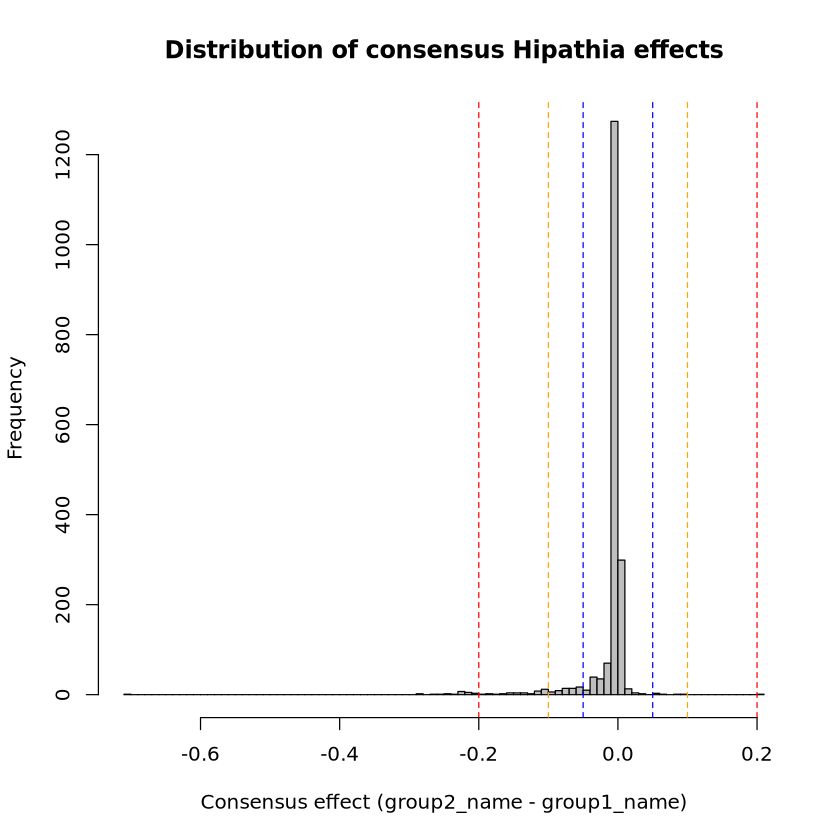

In [55]:
# Basic distribution summary
summary(consensus_eff_sub)

# Fine quantile grid (detect skewness and tails)
qs <- quantile(
  consensus_eff_sub,
  probs = seq(0, 1, by = 0.05),
  na.rm = TRUE
)
cat("\n X% of the values are less than or equal to Y.  \n")
print(qs)

# Direction counts (UP / DOWN / NEUTRAL)
dir_calls <- table(
  ifelse(consensus_eff_sub >  eps_neutral, "UP",
  ifelse(consensus_eff_sub < -eps_neutral, "DOWN", "NEUTRAL")) #eps_neutral <-- Para
)
print(dir_calls)

# Per-patient global shift (bias check)
cat("\nPer-patient mean delta:\n")
print(colMeans(delta_sub, na.rm = TRUE))

# Histogram for visual inspection
hist(
  consensus_eff_sub,
  breaks = 100,
  main = "Distribution of consensus Hipathia effects",
  xlab = "Consensus effect (Tumor - Normal)",
  col = "grey"
)
abline(
  v = c(-0.05, -0.1, -0.2, 0.05, 0.1, 0.2),
  col = c("blue", "orange", "red", "blue", "orange", "red"),
  lty = 2
)

In [59]:
# Threshold diagnostic
eps_grid <- c(0.05, 0.1, 0.15, 0.2, 0.25)

threshold_summary <- do.call(rbind, lapply(eps_grid, function(eps) {
  data.frame(
    eps = eps,
    n_UP      = sum(consensus_eff_sub >  eps, na.rm = TRUE),
    n_DOWN    = sum(consensus_eff_sub < -eps, na.rm = TRUE),
    n_NEUTRAL = sum(abs(consensus_eff_sub) <= eps, na.rm = TRUE)
  )
}))
cat ("Label distribution at different neutrality thresholds \n")
print(threshold_summary)

Label distribution at different neutrality thresholds 
   eps n_UP n_DOWN n_NEUTRAL
1 0.05    7    123      1746
2 0.10    1     63      1812
3 0.15    1     33      1842
4 0.20    1     23      1852
5 0.25    0      5      1871


## 9. Visualization

### 9.1. Heatmap


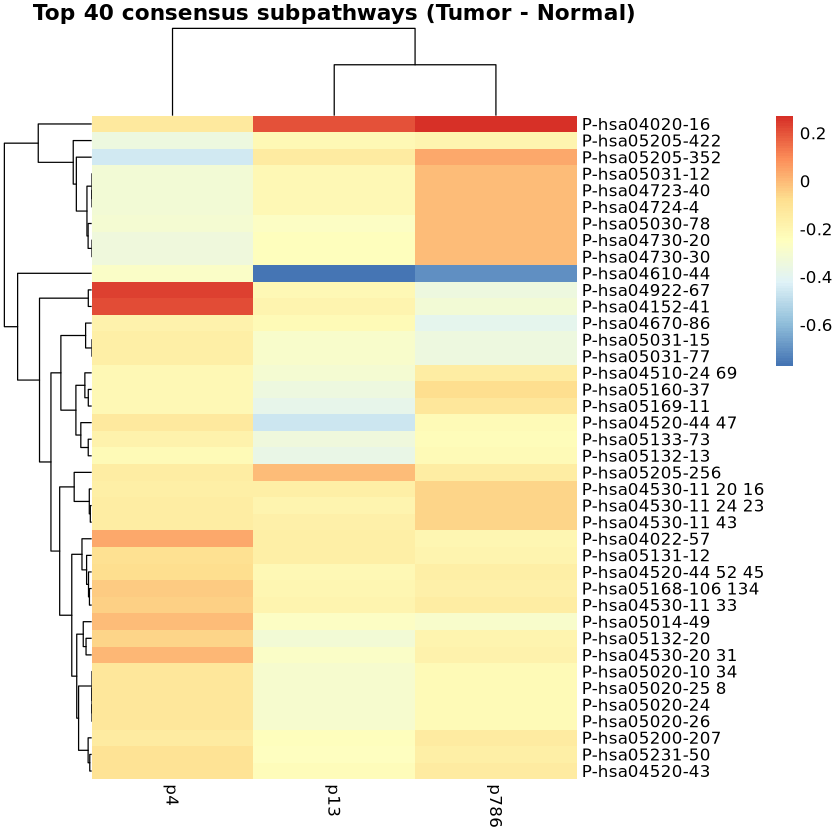

In [35]:
stopifnot(exists("consensus_compact"), exists("delta_sub"), exists("eps_neutral"))

# Top N aus der 8.1 Tabelle nehmen (die ist nach |combined_effect| sortiert) Top_n with combines_effects (8.1.)
top_n <- 40
top_sub <- head(consensus_compact$subpathway, top_n)

# Matrix Heatmap
delta_top <- delta_sub[top_sub, , drop = FALSE]

# Order of the patients
delta_top <- delta_top[, c("p4","p13","p786"), drop = FALSE]  

#Heatmap
pheatmap::pheatmap(
  delta_top,
  main = paste0("Top ", top_n, " consensus subpathways (Tumor - Normal)"),
  clustering_method = "ward.D2",
  scale = "none",
  border_color = NA
)


### 9.2. Pathway-Level Aggregation

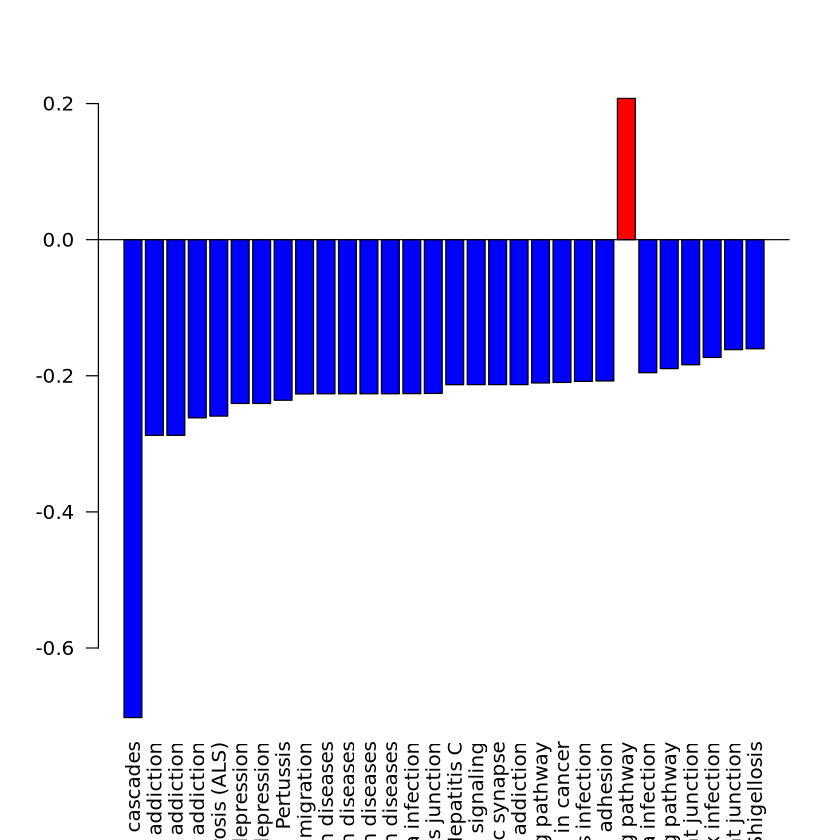

In [37]:
top_n <- 30
df <- head(consensus_compact, top_n)

barplot(
  df$combined_effect,
  names.arg = df$pathway_label,
  las = 2,
  col = ifelse(df$combined_effect > 0, "red", "blue")
)
abline(h = 0)


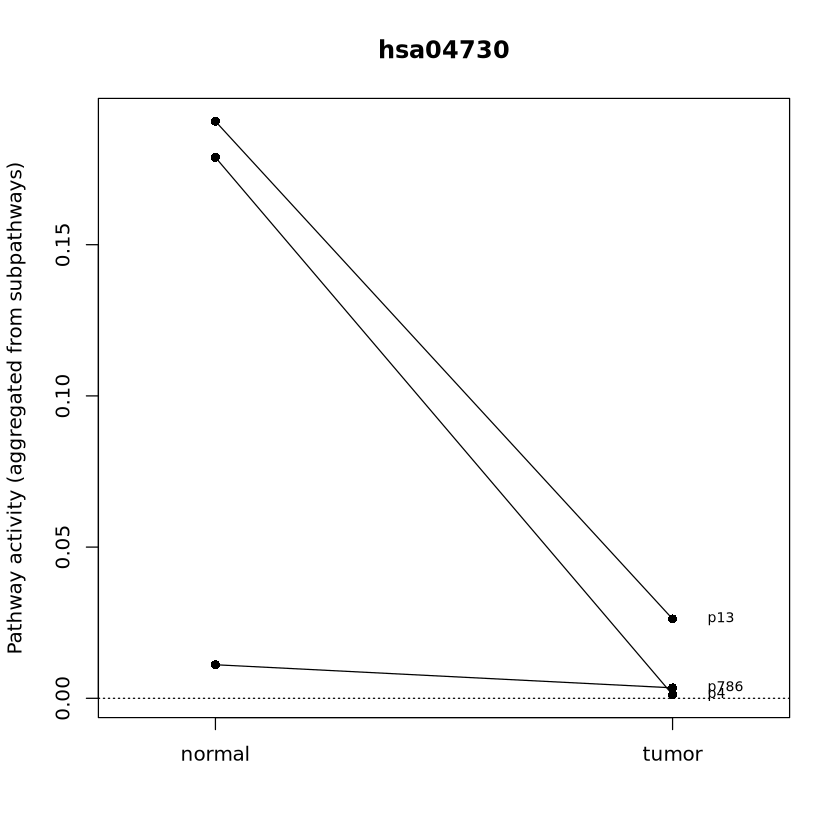

In [63]:
stopifnot(exists("pm_pg"), exists("pw_tab"), exists("group1_name"), exists("group2_name"))

top_n <- 12
top_pw <- head(pw_tab$pathway_id, min(top_n, nrow(pw_tab)))

# 1) map subpathway -> pathway_id using pm_pg rownames
sp <- rownames(pm_pg)
pw_id_from_sp <- sub("^P-(hsa[0-9]+).*", "\\1", sp)

# 2) get paired patients from pm_pg columns like "p4_normal", "p4_tumor"
cn <- colnames(pm_pg)
patients_normal <- unique(sub("_(.*)$", "", cn[grepl(paste0("_", group1_name, "$"), cn)]))
patients_tumor  <- unique(sub("_(.*)$", "", cn[grepl(paste0("_", group2_name, "$"), cn)]))
paired_patients <- sort(intersect(patients_normal, patients_tumor))
stopifnot(length(paired_patients) > 0)

# 3) aggregate subpathways -> pathway activity per patient-group (median across subpathways)
#    returns a matrix: pathways x (patient_group columns)
get_pathway_activity <- function(pid) {
  idx <- pw_id_from_sp == pid
  stopifnot(any(idx))
  apply(pm_pg[idx, , drop = FALSE], 2, median, na.rm = TRUE)
}

# For each pathway, build a small matrix: patients x 2 (normal, tumor)
plot_pathway_slope <- function(pid) {
  v <- get_pathway_activity(pid)
  normal_cols <- paste0(paired_patients, "_", group1_name)
  tumor_cols  <- paste0(paired_patients, "_", group2_name)

  # make sure columns exist
  stopifnot(all(normal_cols %in% names(v)), all(tumor_cols %in% names(v)))

  normal_vals <- v[normal_cols]
  tumor_vals  <- v[tumor_cols]

  # Plot
  x <- c(1, 2)
  ylim <- range(c(normal_vals, tumor_vals), na.rm = TRUE)

  plot(x, c(NA, NA),
       xlim = c(0.8, 2.2), ylim = ylim,
       xaxt = "n",
       xlab = "", ylab = "Pathway activity (aggregated from subpathways)",
       main = pid)

  axis(1, at = c(1,2), labels = c(group1_name, group2_name))

  # lines per patient
  for (i in seq_along(paired_patients)) {
    lines(x, c(normal_vals[i], tumor_vals[i]))
    points(1, normal_vals[i], pch = 16)
    points(2, tumor_vals[i],  pch = 16)
    text(2.05, tumor_vals[i], labels = paired_patients[i], cex = 0.7, pos = 4)
  }

  abline(h = 0, lty = 3)
}

# 4) loop through top pathways
for (pid in top_pw) {
  plot_pathway_slope(pid)
}

### Spielen